<a href="https://colab.research.google.com/github/karen-pal/notebook/blob/main/clip_interrogator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CLIP Interrogator 2.4 by [@pharmapsychotic](https://twitter.com/pharmapsychotic)

Want to figure out what a good prompt might be to create new images like an existing one? The CLIP Interrogator is here to get you answers!

<br>

For Stable Diffusion 1.X choose the **ViT-L** model and for Stable Diffusion 2.0+ choose the **ViT-H** CLIP Model.

This version is specialized for producing nice prompts for use with Stable Diffusion and achieves higher alignment between generated text prompt and source image. You can try out the old [version 1](https://colab.research.google.com/github/pharmapsychotic/clip-interrogator/blob/v1/clip_interrogator.ipynb) to see how different CLIP models ranks terms.

You can also run this on HuggingFace and Replicate<br>
[![Generic badge](https://img.shields.io/badge/🤗-Open%20in%20Spaces-blue.svg)](https://huggingface.co/spaces/pharma/CLIP-Interrogator) [![Replicate](https://replicate.com/pharmapsychotic/clip-interrogator/badge)](https://replicate.com/pharmapsychotic/clip-interrogator)

<br>

If this notebook is helpful to you please consider buying me a coffee via [ko-fi](https://ko-fi.com/pharmapsychotic) or following me on [twitter](https://twitter.com/pharmapsychotic) for more cool Ai stuff. 🙂

And if you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [1]:
!conda

/bin/bash: line 1: conda: command not found


In [1]:
#@title Check GPU
!nvidia-smi -L

GPU 0: NVIDIA A30 (UUID: GPU-0d58720e-34f6-3fd5-510d-e6d5249693f4)
GPU 1: NVIDIA A10 (UUID: GPU-7a841c0c-c63d-437a-8021-22de1168a9f7)


In [2]:
#@title Setup
import os, subprocess

def setup():
    install_cmds = [
        ['pip', 'install', 'gradio'],
        ['pip', 'install', 'open_clip_torch'],
        ['pip', 'install', 'clip-interrogator'],
    ]
    for cmd in install_cmds:
        print(subprocess.run(cmd, stdout=subprocess.PIPE).stdout.decode('utf-8'))

setup()


caption_model_name = 'blip-large' #@param ["blip-base", "blip-large", "git-large-coco"]
clip_model_name = 'ViT-L-14/openai' #@param ["ViT-L-14/openai", "ViT-H-14/laion2b_s32b_b79k"]

import gradio as gr
from clip_interrogator import Config, Interrogator

config = Config()
config.clip_model_name = clip_model_name
config.caption_model_name = caption_model_name
ci = Interrogator(config)

def image_analysis(image):
    image = image.convert('RGB')
    image_features = ci.image_to_features(image)

    top_mediums = ci.mediums.rank(image_features, 5)
    top_artists = ci.artists.rank(image_features, 5)
    top_movements = ci.movements.rank(image_features, 5)
    top_trendings = ci.trendings.rank(image_features, 5)
    top_flavors = ci.flavors.rank(image_features, 5)

    medium_ranks = {medium: sim for medium, sim in zip(top_mediums, ci.similarities(image_features, top_mediums))}
    artist_ranks = {artist: sim for artist, sim in zip(top_artists, ci.similarities(image_features, top_artists))}
    movement_ranks = {movement: sim for movement, sim in zip(top_movements, ci.similarities(image_features, top_movements))}
    trending_ranks = {trending: sim for trending, sim in zip(top_trendings, ci.similarities(image_features, top_trendings))}
    flavor_ranks = {flavor: sim for flavor, sim in zip(top_flavors, ci.similarities(image_features, top_flavors))}

    return medium_ranks, artist_ranks, movement_ranks, trending_ranks, flavor_ranks

def image_to_prompt(image, mode):
    ci.config.chunk_size = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    ci.config.flavor_intermediate_count = 2048 if ci.config.clip_model_name == "ViT-L-14/openai" else 1024
    image = image.convert('RGB')
    if mode == 'best':
        return ci.interrogate(image)
    elif mode == 'classic':
        return ci.interrogate_classic(image)
    elif mode == 'fast':
        return ci.interrogate_fast(image)
    elif mode == 'negative':
        return ci.interrogate_negative(image)



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 787.8/787.8 kB 8.9 MB/s eta 0:00:0000:0100:01



Loading caption model blip-large...


Loading CLIP model ViT-L-14/openai...


ViT-L-14_openai_artists.safetensors: 100%|█| 16.2M/16.2M [00:01<00:00, 11.0MB/s]
ViT-L-14_openai_flavors.safetensors: 100%|███| 155M/155M [00:07<00:00, 20.8MB/s]
ViT-L-14_openai_mediums.safetensors: 100%|████| 146k/146k [00:00<00:00, 472kB/s]
ViT-L-14_openai_movements.safetensors: 100%|██| 307k/307k [00:00<00:00, 696kB/s]
ViT-L-14_openai_trendings.safetensors: 100%|██| 111k/111k [00:00<00:00, 425kB/s]
ViT-L-14_openai_negative.safetensors: 100%|█| 63.2k/63.2k [00:00<00:00, 426kB/s]

Loaded CLIP model and data in 30.38 seconds.


In [3]:
#@title Image to prompt! 🖼️ -> 📝

def prompt_tab():
    with gr.Column():
        with gr.Row():
            image = gr.Image(type='pil', label="Image")
            with gr.Column():
                mode = gr.Radio(['best', 'fast', 'classic', 'negative'], label='Mode', value='best')
        prompt = gr.Textbox(label="Prompt")
    button = gr.Button("Generate prompt")
    button.click(image_to_prompt, inputs=[image, mode], outputs=prompt)

def analyze_tab():
    with gr.Column():
        with gr.Row():
            image = gr.Image(type='pil', label="Image")
        with gr.Row():
            medium = gr.Label(label="Medium", num_top_classes=5)
            artist = gr.Label(label="Artist", num_top_classes=5)
            movement = gr.Label(label="Movement", num_top_classes=5)
            trending = gr.Label(label="Trending", num_top_classes=5)
            flavor = gr.Label(label="Flavor", num_top_classes=5)
    button = gr.Button("Analyze")
    button.click(image_analysis, inputs=image, outputs=[medium, artist, movement, trending, flavor])

with gr.Blocks() as ui:
    with gr.Tab("Prompt"):
        prompt_tab()
    with gr.Tab("Analyze"):
        analyze_tab()

ui.launch(show_api=False, debug=False)


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


In [18]:
!unzip 'laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models.zip'


Archive:  laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models.zip
   creating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0001.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0002.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at de

  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0040.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0041.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0042.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0043.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data dist

  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0082.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0083.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0084.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0085.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data dist

  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0121.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0122.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0123.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0124.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data dist

  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0160.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0161.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0162.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0163.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data dist

  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0199.png  
  inflating: laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models/frame0200.png  


In [17]:
!rm -rf framesback

In [19]:
!mv 'laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models' framesback


In [7]:
!mv 'laying down on my bed, falling inside my own body, me trying to wake up. in my dreams i have seen this random data distribution POV EYE looking at denoising-diffusion-probabilistic-models' frames


zebra print fabric with a blue and white stripe pattern, film still from an cartoon, golden ribbons, lapis lazuli gradients, procedurally generated, medal, dynamic closeup, by Georgia O'Keeffe, youtube video screenshot, intricate pasta waves, repetition, white plank siding, simple chromatic xray, golden thread, winning award image


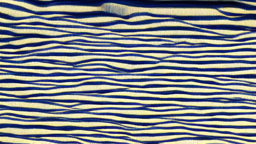

Generating prompts:  50%|██████████▌          | 101/200 [46:00<46:06, 27.94s/it]

a close up of a black and white striped fabric with a pattern, azure waves of water, youtube video screenshot, by Ross Bleckner, unmistakably kenyan, animation illustrative style, sapphire waters below, 1966, flowing rhythms, fine grain texture, textures. com, screengrab, dark blue water, design milk, atoms floating, thick lines


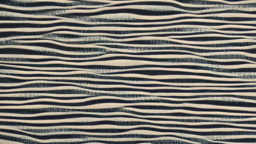

Generating prompts:  51%|██████████▋          | 102/200 [46:35<48:50, 29.90s/it]

a close up of a blue and yellow striped fabric with waves, still frame from a movie, 60s, computer art, made purely out of water, subtle junji ito, paper texture. 1968, from lorax movie, intricate painting, pixar (2018)


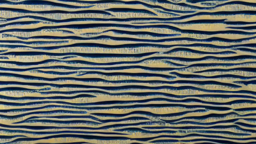

Generating prompts:  52%|██████████▊          | 103/200 [46:57<44:33, 27.56s/it]

a close up of a zebra print fabric with a black and white stripe, blue - ray screenshot, by Louise Bourgeois, dmt waves, between sedimentary deposits, featured on dribble, single panel, rapids, 2 0 1 4. modern attire, one line art, blues, flowing rhythms, width 1 0 2 4, high definition detail


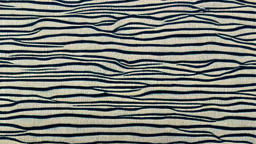

Generating prompts:  52%|██████████▉          | 104/200 [47:28<45:56, 28.71s/it]

a close up of a blue and white rug with wavy lines, still frame from a movie, tiktok video, extremely detailed water texture, by Jiro Yoshihara, digital art - w 640, similar aesthetics to picasso, beautiful wallpaper, timelapse, connecting lines, manga panel, pristine rippling oceanic waves


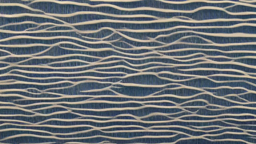

Generating prompts:  52%|███████████          | 105/200 [47:56<45:06, 28.49s/it]

a close up of a zebra print fabric with a black and white stripe, by Louise Bourgeois, deep blue water, 1976 magazine cover, creating an optical illusion, screengrab, high quality fabrics textiles, connecting lines, salt dunes, 60s, terraces, textures. com, by Osamu Tezuka, rectangular


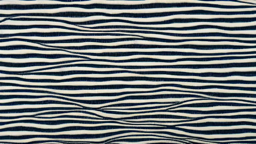

Generating prompts:  53%|███████████▏         | 106/200 [48:28<46:17, 29.55s/it]

a close up of a blue and white textured fabric with a pattern, still from a music video, by David Firth, fractal wave interference, youtube video screenshot, deep learning, unknown pleasures, noodles, in thick layers of rhythms, mesh shirt, water swirling, swirling schools of silver fish, 15081959 21121991 01012000 4k


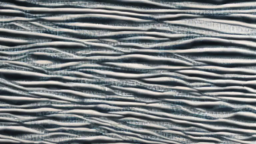

Generating prompts:  54%|███████████▏         | 107/200 [48:55<44:39, 28.81s/it]

a close up of a piece of art with a blue border, still from a music video, grey striped walls, extremely textured, synthetic polymer paint on linen, blossoming rhythm, rapids, stacked image, many zippers, by Geoffrey Olsen, crosshatching, 2 d render, trending on juxtapoz magazine, cyanotype, ai art


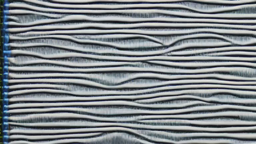

Generating prompts:  54%|███████████▎         | 108/200 [49:28<45:46, 29.85s/it]

a close up of a snow covered surface with a bird flying in the sky, deepdream, denim hot-pants, ripples, long blue-cape, folds, torment and waves, kubric stare, terraces, twisted wire, extremely high definition, blue archive, still frame from a movie, by Georgia O'Keeffe, linen, shirtless :: high detail


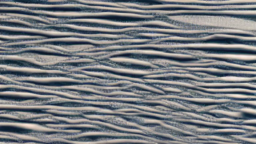

Generating prompts:  55%|███████████▍         | 109/200 [50:00<46:08, 30.42s/it]

a close up of a blue and white striped cloth with a blue border, eero aarnio, slow motion fashion, abstracted painterly techniques, unknown pleasures, black pen drawn edges, trending on artstaion, philip taaffe, ripple, long flowing fins, art »


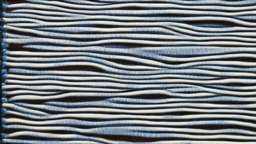

Generating prompts:  55%|███████████▌         | 110/200 [50:22<42:10, 28.12s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, smooth concrete, by Georgia O'Keeffe, spooky netflix still shot, woodblock, water bubbles, ex machina (2014), trending on artstaton, denim


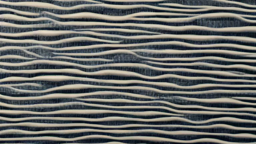

Generating prompts:  56%|███████████▋         | 111/200 [50:43<38:23, 25.88s/it]

a close up of a piece of fabric with wavy lines, british stopmotion, blue archive, by Giorgio Morandi, youtube video screenshot, mixed techniques, denim, japanese woodblock, soft zen minimalist, white noise, long flowing fins, animation, an ai generated image, stitching


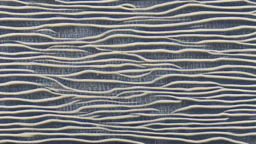

Generating prompts:  56%|███████████▊         | 112/200 [51:11<39:04, 26.64s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, contemporary ceramics, deep learning, by Nína Tryggvadóttir, made purely out of water, stylized thin lines, patterned clothing, aspect ratio 16:9, sleek flowing shapes, inspired by Frederick Hammersley


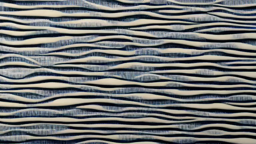

Generating prompts:  56%|███████████▊         | 113/200 [51:35<37:21, 25.77s/it]

a close up of a blue and white striped fabric with waves, surreal woodcut engraving, eero aarnio, wave frequencies, by Ambrose McCarthy Patterson, screengrab, pouring techniques, mid century art, radiohead album cover, lake scene, hypnotic, high detail 1024


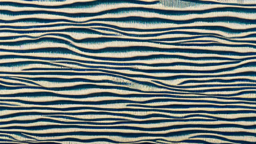

Generating prompts:  57%|███████████▉         | 114/200 [51:59<36:00, 25.13s/it]

a close up of a blue and white striped fabric with a pattern, stop-motion film (1924), dmt waves, the style of andy warhol, by Georgia O'Keeffe, pen painting, inspired by Louise Bourgeois, calm seas, youtube video screenshot, 1965, diviantart, ripple, vague


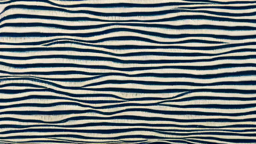

Generating prompts:  57%|████████████         | 115/200 [52:26<36:24, 25.70s/it]

a close up of a piece of fabric with a pattern of wavy lines, by Georgia O'Keeffe, youtube video screenshot, dreams of silver surfer, surreal woodblock print, subtle color variations, simulation of water splashes, by Vija Celmins, aspect ratio 16:9, kinetic art, tonalism illustration, blue image


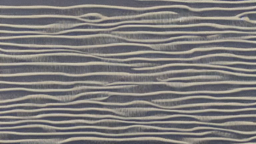

Generating prompts:  58%|████████████▏        | 116/200 [52:51<35:55, 25.66s/it]

a close up of a blue and white striped fabric with a pattern, by Ellen Gallagher, in an african river, award-winning painting, inspired by J. Alden Weir, 2d side view, radiohead album cover, inspired by Władysław Ślewiński, electron flow, terraces, antialiasing


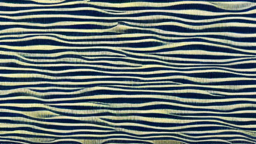

Generating prompts:  58%|████████████▎        | 117/200 [53:16<35:11, 25.45s/it]

a close up of a wall with a pattern of wavy lines, 1 9 7 0 s analog video, deep blue water color, naturalistic technique, ultra realist soft painting, swirling schools of silver fish, 1965, noise to volume, elegant fabric, youtube video screenshot, single panel, by David Diao


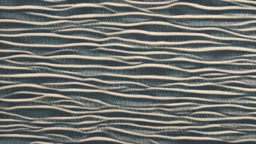

Generating prompts:  59%|████████████▍        | 118/200 [53:42<34:53, 25.54s/it]

a close up of a painting of a wave pattern on a blue background, 1960's olympics footage, animation still screencap, rivers, by Gwenny Griffiths, still from a 2015 pixar movie, etched relief, depth blur, textured, connecting lines, realistic textured


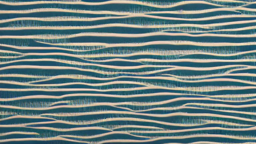

Generating prompts:  60%|████████████▍        | 119/200 [54:07<34:07, 25.28s/it]

a close up of a blue and white striped fabric with a pattern, photoshop water art, inspired by Alex Katz, supercomputers text to images, stereogram, inspired by Christo, sound wave, three dimensions, by Germán Londoño, detail, ripple


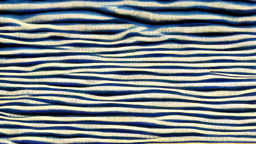

Generating prompts:  60%|████████████▌        | 120/200 [54:33<34:03, 25.54s/it]

a close up of a blue and white striped fabric with a pattern, screenshot from the 1983 film, by Georgia O'Keeffe, reaction diffusion, etched relief, turbulent waves, aspect ratio 16:9, detailed oil paint, hypnotic dimensions, morph dna, 1 9 6 0 s art, grass and water


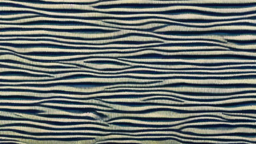

Generating prompts:  60%|████████████▋        | 121/200 [55:00<34:06, 25.91s/it]

a close up of a blue and white striped cloth with a black border, by Sylvia Snowden, computer art, highly detailed and hypnotic, inspired by Richard Artschwager, ocean sprites, various refining techniques, terraces, inspired by Hans Erni, ca. 2001, reeds, aspect ratio 16:9, detailed oil


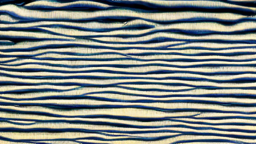

Generating prompts:  61%|████████████▊        | 122/200 [55:29<34:57, 26.89s/it]

a close up of a black and white striped fabric with waves, 1 9 7 0 s analog video, blue archive, 1960s illustration, naturalistic technique, noir animation, inspired by Jozef Czapski, flat water color texture, autechre, navy-blue, italo calvino


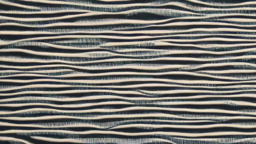

Generating prompts:  62%|████████████▉        | 123/200 [55:53<33:21, 26.00s/it]

a painting of a blue and yellow striped pattern on a wall, water world, by Richard Artschwager, one of the weavers of destiny, stylised textures, zoomed in, sapphires, aspect ratio 16:9, by Jane Freeman, instagram art, shipibo


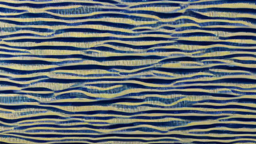

Generating prompts:  62%|█████████████        | 124/200 [56:16<32:00, 25.27s/it]

a close up of a black and white striped fabric with waves, 1 9 7 0 s analog video, brushed white and blue paint, junki ito, pouring techniques, done in the style of matisse, toned paper, navy-blue, by John McLaughlin, youtube video screenshot, trending on artsy, surface hives


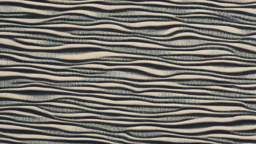

Generating prompts:  62%|█████████████▏       | 125/200 [56:42<31:44, 25.40s/it]

a painting of a blue and white striped pattern on a wall, videotape still from 1985, ocean simulation, supercomputer, rivers and lakes, tonal topstitching, inspired by Milton Avery, finely textured, blue and gold, highly detailed and hypnotic, etched relief, youtube video screenshot, aspect ratio 16:9, woodblock


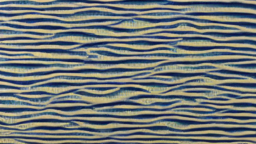

Generating prompts:  63%|█████████████▏       | 126/200 [57:11<32:35, 26.43s/it]

a close up of a wall with a pattern of wavy lines, screenshot from a movie, by Louise Abbéma, midcentury modern, ocean sprites, youtube video screenshot, blue: 0.5, tonal topstitching, deep learning, rapids, stylistic furniture, by Georgia O'Keeffe, cg animation, textured like a carpet, trending on dezeen


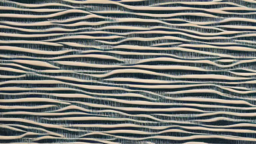

Generating prompts:  64%|█████████████▎       | 127/200 [57:41<33:39, 27.67s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, art jiro matsumoto, inspired by Georgia O'Keeffe, luxurious onsens, youtube video screenshot, highly detailed and hypnotic, a woodcut, pat steir, high detail 1024, surface hives, reef, hard surfaces


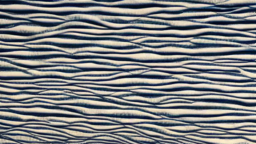

Generating prompts:  64%|█████████████▍       | 128/200 [58:07<32:32, 27.12s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, by Matteo Pérez, unique and intricate painting, inspired by David Chipperfield, unknown pleasures, 2 0 1 5 live music video, flat water color texture, many smooth curves, stylised design, youtube video screenshot, iintricate


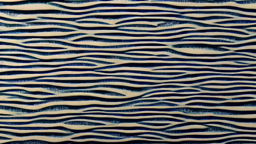

Generating prompts:  64%|█████████████▌       | 129/200 [58:33<31:46, 26.85s/it]

a close up of a black and white photo of a wall, woven with electricity, super slowmotion, clouds on surface, deep learning, wet reflective concrete, metal shutter, experimental techniques, by Richard Artschwager, youtube video screenshot, stacked image, by David Chipperfield, vine art, watery


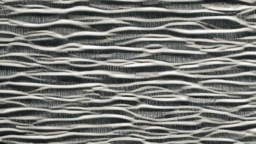

Generating prompts:  65%|█████████████▋       | 130/200 [59:02<31:46, 27.23s/it]

a close up of a blue fabric with a wave pattern, high reflections oil, focus stacking, by Georgia O'Keeffe, inspired by Richard Artschwager, metal shutter, radiohead album cover, reeds, award-winning painting, ripple


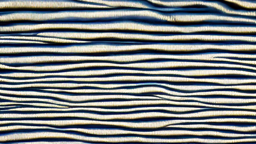

Generating prompts:  66%|█████████████▊       | 131/200 [59:22<28:58, 25.19s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, by Wolfgang Zelmer, the thames is dry, landscape of geometric shapes, smooth brushwork, in this painting, coherent symmetry, fish scales, screengrab, connecting lines, reef, etched relief, soft zen minimalist


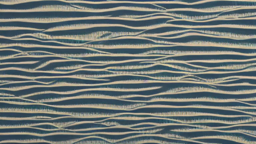

Generating prompts:  66%|█████████████▊       | 132/200 [59:52<30:16, 26.71s/it]

a close up of a blue and black striped fabric with a wave pattern, still from a music video, iridescent reflections, david rudnick, melting into rivers, cartoon network stillframe, dvd screencapture, tiger stripes, 5 d, xerography, 2015 cinematography, fishcore, high - definition picture, trending on artstattion, fluid energy


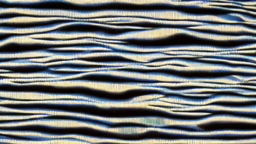

Generating prompts:  66%|████████████▋      | 133/200 [1:00:26<32:06, 28.76s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, by Matteo Pérez, white ceramic shapes, intricate symmetrical artwork, denim, fish scales, black pen drawn edges, 2 0 1 5 live music video, very grainy texture, and blue, smooth texture, smooth clean surfaces, design milk, woodblock, finely textured


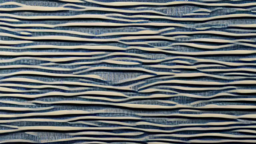

Generating prompts:  67%|████████████▋      | 134/200 [1:01:04<34:54, 31.74s/it]

a close up of a black and white photo of a wall, made of money, layered paper art, sound waves, from the sandman netflix show, award - winning pencil drawing, by Georgia O'Keeffe, youtube video screenshot, instagram art, concrete steel glass, 16k 3d, quilt, wavy water, by Carol Bove, gray color


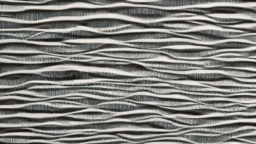

Generating prompts:  68%|████████████▊      | 135/200 [1:01:38<35:06, 32.40s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, black ambient background, by Richard Artschwager, connecting lines, concrete art style, shimmering iridescent water, in this painting, etched relief, autechre, rapids, reptilian skin, aspect ratio 16:9


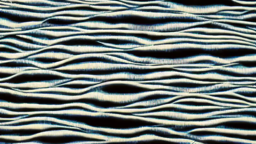

Generating prompts:  68%|████████████▉      | 136/200 [1:02:07<33:19, 31.24s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, by David Chipperfield, engraved texture, metallic reflections, supercomputer, fish flocks, inspired by Eduardo Lefebvre Scovell, smooth brushwork, by Pierre Soulages, 2506921471


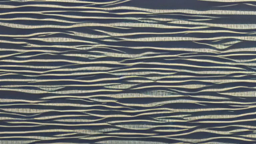

Generating prompts:  68%|█████████████      | 137/200 [1:02:31<30:40, 29.22s/it]

a close up of a blue and yellow striped fabric, computer painting, inspired by Richard Artschwager, water sprites, highly detailed and hypnotic, obi strip, screengrab, reeds, rapids, by Ian Fairweather, opart, terraces, award-winning painting, single line, medium detail


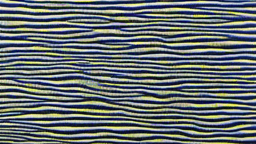

Generating prompts:  69%|█████████████      | 138/200 [1:03:03<30:54, 29.90s/it]

a close up of a yellow and blue striped fabric, flowing rhythms, in an african river, korean artist, inspired by Władysław Ślewiński, inspired by Kusama, oil on panel, terraces, 2016, under water, aboriginal engraving, rectangular, flowing tendrils, calm waves, standing in a shallow river


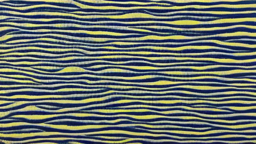

Generating prompts:  70%|█████████████▏     | 139/200 [1:03:36<31:26, 30.93s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, by David Chipperfield, ffffound, omori, the thames is dry, intricate texture, computer screens, calm waves, by Jon Coffelt, stylized painterly, embossed, youtube video screenshot, by John Cale


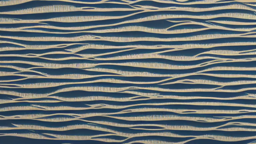

Generating prompts:  70%|█████████████▎     | 140/200 [1:04:04<29:56, 29.94s/it]

a close up of a blue and white striped fabric with a wave pattern, art jiro matsumoto, youtube video screenshot, etched relief, staggered terraces, by Georgia O'Keeffe, heavy grain-s 150, artistic lithography, hypnotic dimensions, aspect ratio 16:9, in an african river, morph dna, serial art


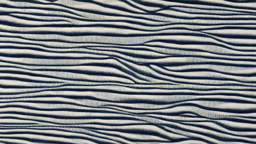

Generating prompts:  70%|█████████████▍     | 141/200 [1:04:30<28:22, 28.86s/it]

a close up of a zebra print fabric with a blue and white stripe, gutai group, youtube video screenshot, 1950s art deco, pouring techniques, seascape, by Tsuji Kakō, inspired by Nathaniel Pousette-Dart, wooden decoration, turbulent waves, diviantart, tom jobim, 1954


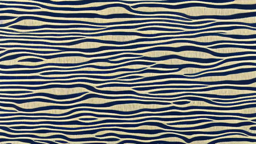

Generating prompts:  71%|█████████████▍     | 142/200 [1:04:58<27:33, 28.52s/it]

a close up of a zebra print fabric with a black and white stripe, by Louise Bourgeois, blue - ray screenshot, by Georgia O'Keeffe, dark blue water, louis kahn, animation still, 1 9 5 5, dmt waves, trending on artforum, ( ( ( surrealism ) ) ), unmistakably kenyan, saatchi art


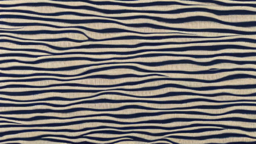

Generating prompts:  72%|█████████████▌     | 143/200 [1:05:24<26:15, 27.64s/it]

a close up of a zebra print fabric with a black and white stripe, by Louise Bourgeois, dark blue and white robes, screengrab, inspired by Brett Whiteley, museum catalog photography, year 1968, shipibo, aboriginal, listing image, waves, naturalistic technique, 1 9 6 0 s art, cords, terraces


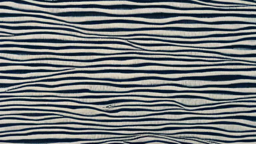

Generating prompts:  72%|█████████████▋     | 144/200 [1:05:54<26:36, 28.50s/it]

a close up of a blue and white wall with a pattern of wavy lines, 8 k time - lapse functions, heavy impasto technique, half submerged in water, its a deep dream, made of paperclips, super slowmotion, smooth concrete, noisy filter, beautiful flowing fabric, by Amelia Peláez, 4096k film, glass wall


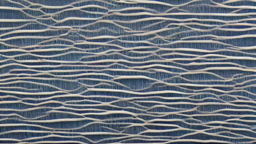

Generating prompts:  72%|█████████████▊     | 145/200 [1:06:21<25:38, 27.97s/it]

a close up of a wall with a pattern of wavy lines, blue undergarments, inspired by Vija Celmins, experimental techniques, in an african river, illustration:.4, cloth head wrap, hypnotic dimensions, repetition, sand banks, johfra, indigo filter, aspect ratio 16:9, threads, panini


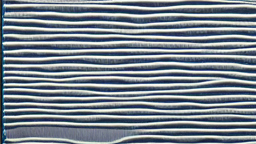

Generating prompts:  73%|█████████████▊     | 146/200 [1:06:53<26:22, 29.31s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, feng zhu |, smooth shapes and lines, naturalistic technique, stippled walls, by Frederick Hammersley, youtube video screenshot, highly detailed and hypnotic, denim, noir animation, mingei, deep learning, mit technology review, trending on juxtapoz magazine


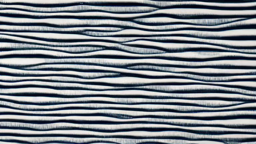

Generating prompts:  74%|█████████████▉     | 147/200 [1:07:24<26:23, 29.88s/it]

a close up of a piece of fabric with a wavy design, youtube video screenshot, blue archive, stillframe, denim, 15081959 21121991 01012000 4k, lines and movement and motion, stopmotion animation, screenshot from a movie, glass wall, 2 0 1 5 live music video


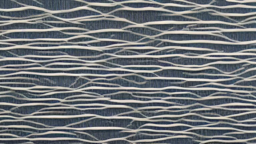

Generating prompts:  74%|██████████████     | 148/200 [1:07:47<23:58, 27.67s/it]

a close up of a black and white striped fabric with a pattern, eero aarnio, in this painting, filaments, by Osamu Tezuka, small rectangular glasses, flowing rhythms, blue and white tones, flat brush strokes, listing image, morph dna, hypnotic dimensions


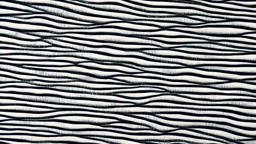

Generating prompts:  74%|██████████████▏    | 149/200 [1:08:14<23:22, 27.49s/it]

a close up of a metal mesh with a pattern of wavy lines, still frame from a movie, impossible object, washing machine, swirling schools of silver fish, painted metal, single panel, connecting lines, blingee, grey cloth, long vines, harp, balconies, wikiart, metal lid, very grainy texture, .ai, 15081959 21121991 01012000 4k


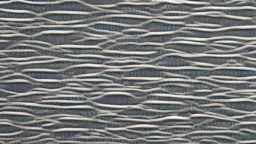

Generating prompts:  75%|██████████████▎    | 150/200 [1:08:52<25:34, 30.68s/it]

a close up of a piece of fabric with a wave pattern, british stopmotion, stripes, slow motion, jony ives, lined up horizontally, shirtless :: high detail, deep blues, zippers, trending on artstaion, inspired by David Inshaw, denim, repetitiveness, fine pen work, animated, highlydetailed


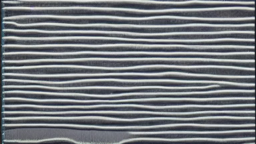

Generating prompts:  76%|██████████████▎    | 151/200 [1:09:26<25:53, 31.71s/it]

a close up of a snow covered surface with a blue sky, inspired by Bridget Riley, video still, psychedelic swimsuit, denim, stop-motion film (1924), wearing stripe shirt, by Georgia O'Keeffe, super slowmotion, marvelous designer, deep blue oceans, flowing silk sheets, aspect ratio 16:9, trending on artsy


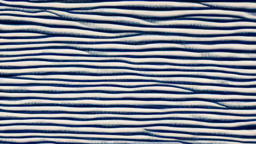

Generating prompts:  76%|██████████████▍    | 152/200 [1:09:56<24:52, 31.09s/it]

a close up of a black and white striped fabric with a pattern, 1 9 7 0 s analog video, deep blue oceans, animation style render, by Georgia O'Keeffe, youtube video screenshot, wavy water, trending on artstration, stopmotion animation, in this painting, repetition, 60s, reaction diffusion, woodblock, navy


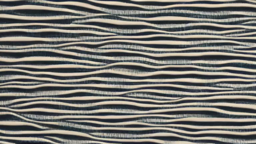

Generating prompts:  76%|██████████████▌    | 153/200 [1:10:27<24:27, 31.21s/it]

a close up of a blue and yellow striped fabric with waves, youtube video screenshot, by Max Gubler, waterscape, aboriginal art, optical illusion woodblock print, in thick layers of rhythms, aspect ratio 16:9, paddy fields and river flowing, pouring techniques, ( ( dither ) ), inspired by Milton Avery, water sprites, detail


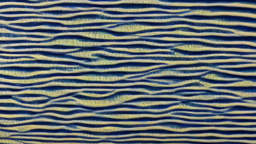

Generating prompts:  77%|██████████████▋    | 154/200 [1:10:56<23:16, 30.35s/it]

a close up of a blue and white wall with a wave pattern, still frame from a movie, art on instagram, 60s, finely textured, connecting lines, contemporary ceramics, aquatic devices, rectangular pool, etched relief, sound waves, mixed techniques, masterpieceunderwater scene, elegant fabric, youtube video screenshot, 6 0 s, 2 0 1 5 live music video


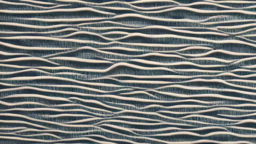

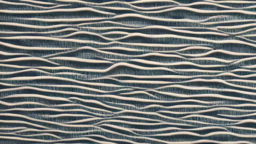

Generating prompts:  78%|██████████████▋    | 155/200 [1:11:28<23:13, 30.97s/it]

a close up of a black and white photo of a wave pattern, by Louise Bourgeois, youtube video screenshot, navy-blue, 1966, 1 8 th century japanese painting, textiles, dmt waves, private collection, without text, by Jiao Bingzhen, eeriewave, flood, featured on artsation


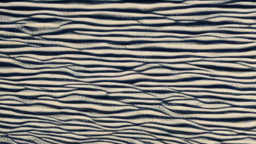

Generating prompts:  78%|██████████████▊    | 156/200 [1:11:56<22:01, 30.03s/it]

a close up of a blue fabric with a wavy design, film still from an cartoon, stripes, 5d, by Justin Currie, high - key photography, deformations, featured on vimeo, filmgrain, ripple, digital matte


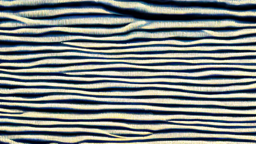

Generating prompts:  78%|██████████████▉    | 157/200 [1:12:18<19:51, 27.71s/it]

a close up of a piece of fabric with a wave pattern, 1965, youtube video screenshot, dark blues, style of ian hubert, pristine rippling oceanic waves, mixed techniques, terraces, parallelism, product image, johfra, very elongated lines, strained expression, zebra, dissolution filter, denim, 60s


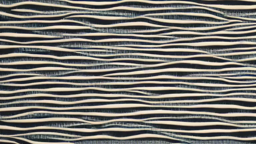

Generating prompts:  79%|███████████████    | 158/200 [1:12:54<21:03, 30.08s/it]

a painting of a blue and yellow striped fabric with waves, videotape still from 1985, water sprites, by Georgia O'Keeffe, microscopic detail, supercomputer, in thick layers of rhythms, etched relief, standing in a shallow river, instagram art, sapphires, aspect ratio 16:9, intricate oil painting detail


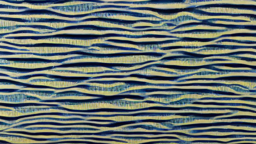

Generating prompts:  80%|███████████████    | 159/200 [1:13:22<20:12, 29.56s/it]

a close up of a painting of a wave pattern on a wall, still from mary poppins (1964), tranquil, teal paper, screengrab, inspired by Ambrose McCarthy Patterson, raft gameplay, offset printing technique, sink ( ( ( fish tank ) ) ) ) ), titled'holiday at the beach ', 5 0 s aesthetic, weaving, by Syd Barrett


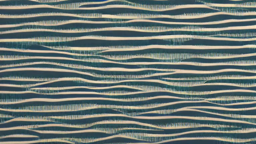

Generating prompts:  80%|███████████████▏   | 160/200 [1:13:49<19:08, 28.72s/it]

a close up of a blue fabric with a wavy design, videotape still from 1985, metallic shutter, black and white television still, microscopic detail, by D. Howard Hitchcock, photolithography, rippling water, staggered terraces, by Pietro Testa, television, 5 d, sharp focus ilustration, in thick layers of rhythms


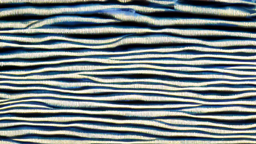

Generating prompts:  80%|███████████████▎   | 161/200 [1:14:21<19:12, 29.56s/it]

a close up of a zebra print fabric with a black and white stripe, blue - ray screenshot, by Georgia O'Keeffe, intricate pasta waves, video still, flat painting, rapids, postminimalism, sapphire waters below, embroidered uniform guard, high definition detail, hypnotic dimensions, youtube video screenshot, 60s, dark blue water


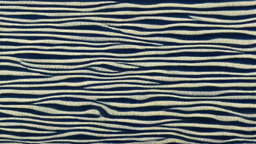

Generating prompts:  81%|███████████████▍   | 162/200 [1:14:55<19:37, 30.98s/it]

a close up of a blue and white striped fabric with a pattern, 1965, treading on calm water, animation still, maybe small waves, hypnotic dimensions, stylized painterly, terraces, drowning, safari background, very grainy texture, mixed techniques, weightlessness, sapphire waters below, extremely sharp lines, reduce duplication interference


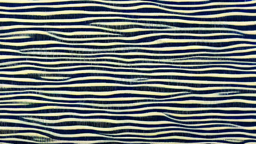

Generating prompts:  82%|███████████████▍   | 163/200 [1:15:31<20:00, 32.44s/it]

a close up of a blue and white striped fabric with waves, still from mary poppins (1964), youtube video screenshot, beautiful high contrast woodcut, water running down the walls, sleek flowing shapes, circa 1969, unknown artstyle, serene field setting, textures. com, 60s, tech pattern, official modern animation, deep learning


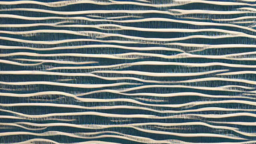

Generating prompts:  82%|███████████████▌   | 164/200 [1:16:02<19:11, 32.00s/it]

a close up of a blue and white striped fabric with a wave pattern, stop-motion film (1924), screenshot from the 1983 film, highly detailed and hypnotic, flat brush strokes, 60s, varying dots, style of angela deane, youtube video screenshot, rectangular, r /art, rapids, clean elegant painting, navy


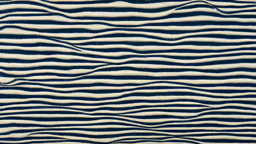

Generating prompts:  82%|███████████████▋   | 165/200 [1:16:32<18:21, 31.46s/it]

a close up of a piece of fabric with a wavy design, screenshot from the 1983 film, by Vija Celmins, youtube video screenshot, style of ian hubert, denim, precise lines, 60s, ultramarine, movement effects, lossless, currents, 9 5


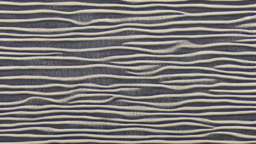

Generating prompts:  83%|███████████████▊   | 166/200 [1:16:59<17:05, 30.16s/it]

a close up of a piece of fabric with a wave pattern, youtube video screenshot, blue archive, by Inshō Dōmoto, japanese woodblock, gray anthropomorphic, reduce duplication interference, detailed white liquid, aspect ratio 16:9, reeds, realistic ocean, rippling, 7 0 - s, heavy grain-s 150


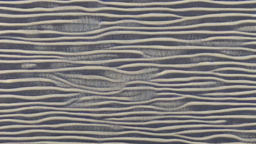

Generating prompts:  84%|███████████████▊   | 167/200 [1:17:28<16:20, 29.71s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, by Eizō Katō, flat brush, white ceramic shapes, water bubbles, finely textured, connecting lines, simplified forms, denim, in an african river, strained expression


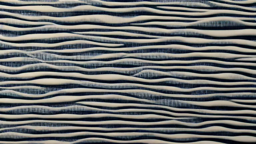

Generating prompts:  84%|███████████████▉   | 168/200 [1:17:53<15:08, 28.40s/it]

a close up of a zebra print fabric with a black and white stripe, blue - ray screenshot, by Georgia O'Keeffe, reaction diffusion, 1960s cartoon, aerial iridecent veins, calm waves, youtube video screenshot, wood planks, gold and cobalt tiles, high definition detail, river rapids, wake initiated lucid dream


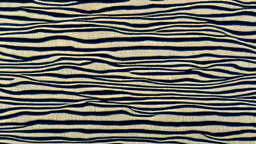

Generating prompts:  84%|████████████████   | 169/200 [1:18:19<14:15, 27.60s/it]

a close up of a snow covered surface with a snowboard, inspired by Richard Artschwager, denim, screenshot from a movie, rippling fabric of reality, blue undergarments, by Israel Tsvaygenbaum, featured on vimeo, dmt waves, anti-aliasing, aspect ratio 1:3, garments, inspired by Jiao Bingzhen


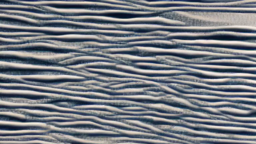

Generating prompts:  85%|████████████████▏  | 170/200 [1:18:44<13:30, 27.00s/it]

a close up of a blue and white rug with a wavy design, still frame from a movie, by Kōno Michisei, denim, 2 0 1 4. modern attire, chiseled formations, by Geoffrey Olsen, animation still screencap, open books, micron, rapids, cuastics, 2 0 1 0 s


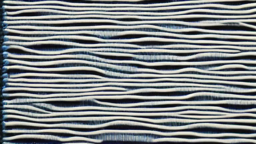

Generating prompts:  86%|████████████████▏  | 171/200 [1:19:13<13:18, 27.55s/it]

a close up of a blue and white painting of waves, still frame from a movie, stylized stone cladding texture, by Kōno Michisei, made purely out of water, flat water color texture, 60s, youtube video screenshot, textiles, noodles, channel 4, by Georgia O'Keeffe


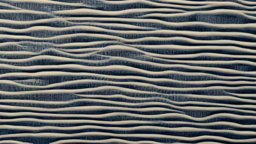

Generating prompts:  86%|████████████████▎  | 172/200 [1:19:40<12:47, 27.42s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, by Eizō Katō, youtube video screenshot, by Georgia O'Keeffe, mid century, water bubbles, wolff olins, japanese onsen, digital animation, high grain, calm water, modulated line, 60s, textured


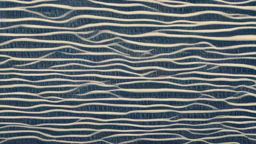

Generating prompts:  86%|████████████████▍  | 173/200 [1:20:15<13:22, 29.71s/it]

a close up of a zebra print fabric with a black and white stripe, by Louise Bourgeois, deep blue water, noise rock album cover, taken in the early 1960s, dmt waves, featured in art magazine, screengrab, catalog print, flowing rhythms, sails


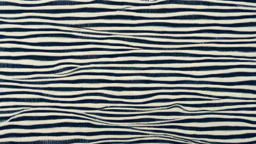

Generating prompts:  87%|████████████████▌  | 174/200 [1:20:39<12:04, 27.88s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, denim jeans, by Mór Adler, 2 0 1 4. modern attire, hints of cronenberg, algorithmic, youtube video screenshot, fine pen work, fish flocks, thin sharp lines, and blue, garments


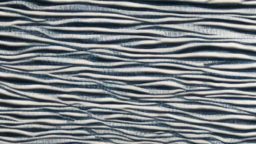

Generating prompts:  88%|████████████████▋  | 175/200 [1:21:11<12:06, 29.06s/it]

a close up of a blue and white wall with a pattern on it, video still, texturized, organic lines, corduroy, heavy impasto technique, made of paperclips, inspired by Richard Artschwager, a painting of white silver, swiping brushwork, loom, in this painting, rapids, one line, deep learning, terraces


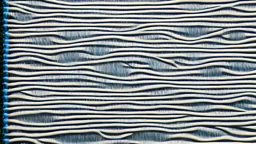

Generating prompts:  88%|████████████████▋  | 176/200 [1:21:44<12:09, 30.40s/it]

a close up of a black and white striped fabric with a pattern, by Louise Bourgeois, an oil painting. wave, connecting lines, made of all white ceramic tiles, blue scales, painting for a wall, pencil painting, sleek flowing shapes, simplified forms, detailed product image, inspired by Carol Bove


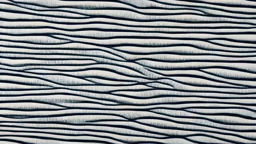

Generating prompts:  88%|████████████████▊  | 177/200 [1:22:11<11:14, 29.30s/it]

a close up of a metal mesh with a pattern of wavy lines, still frame from a movie, ai art, soft lens, brushed white and blue paint, visable sounds waves, metal garments, rapids, connecting lines, audiophile, textures. com, elevator, textile, 7 0 - s, noisy


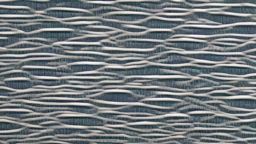

Generating prompts:  89%|████████████████▉  | 178/200 [1:22:44<11:09, 30.44s/it]

a close up of a piece of fabric with wavy lines, youtube video screenshot, style of angela deane, slow motion, deep learning, by Ram Chandra Shukla, denim, connecting lines, de-noise, calm waves, brushed white and blue paint, stop - motion, stereogram, smooth noise, in thick layers of rhythms, # digital 2 d, .ai


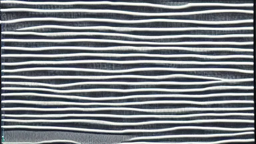

Generating prompts:  90%|█████████████████  | 179/200 [1:23:20<11:14, 32.11s/it]

a close up of a blue and white striped fabric with a pattern, super slowmotion, quentin mabille, corduroy, claymotion, abstracted painterly techniques, inspired by Richard Artschwager, drawn with a single line, salt dunes, motion design, screengrab, by Matteo Pérez, deep learning, strong ambient occlusion


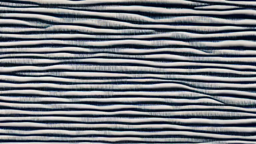

Generating prompts:  90%|█████████████████  | 180/200 [1:23:50<10:29, 31.47s/it]

a close up of a piece of fabric with a blue border, animation still, white plank siding, ripple, white carved abstract sculpture, youtube video screenshot, relief engraving, by Geoffrey Olsen, ripples, cushions, aspect ratio 16:9, google arts and cultures, sound wave, strange formations


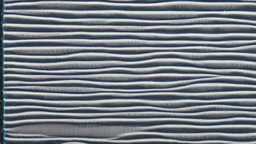

Generating prompts:  90%|█████████████████▏ | 181/200 [1:24:18<09:39, 30.49s/it]

a close up of a blue and white striped fabric with waves, still frame from a movie, deep learning, 60s, by Osamu Tezuka, youtube video screenshot, high grain, incredible fineline, by Georgia O'Keeffe, white ceramic shapes, amazing textured brush strokes, audio waveform, filmgrain, datastream or river


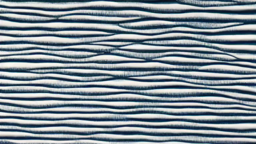

Generating prompts:  91%|█████████████████▎ | 182/200 [1:24:47<08:58, 29.90s/it]

a close up of a blue and white wall with a pattern of wavy lines, still frame from a movie, smart textiles, thick impasto technique, water cuastics, fish flocks, noisy filter, stitching, youtube video screenshot, tonal topstitching, loom, .ai, still from a music video, mingei, super sophisticated texture


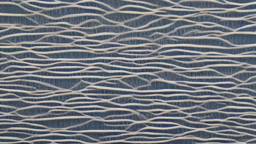

Generating prompts:  92%|█████████████████▍ | 183/200 [1:25:17<08:27, 29.85s/it]

a close up of a zebra print fabric with a black and white stripe, by Bridget Bate Tichenor, stop-motion film (1924), dark blue water, youtube video screenshot, 1960s orientalism, fluid lines, dominique ingres, nate berkus, rapids, louis kahn, weightlessness, rich woodgrain, blues


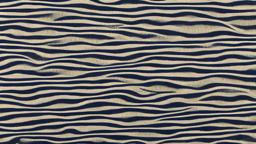

Generating prompts:  92%|█████████████████▍ | 184/200 [1:25:46<07:55, 29.73s/it]

a close up of a zebra print fabric with a black and white stripe, by Louise Bourgeois, trending on art - sation, 1960s, shamanistic dark blue clothes, touareg, philip taaffe, artforum, seascape, listing image, dmt waves, 1959, creative commons attribution, chinese ribbon dance


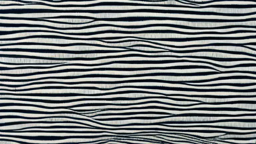

Generating prompts:  92%|█████████████████▌ | 185/200 [1:26:15<07:24, 29.62s/it]

a close up of a blue and white rug with wavy lines, still frame from a movie, water running down the walls, watercolor technique, deep learning, finely textured, made of brushed steel, blue archive, audio waveform, by Miwa Komatsu, stop frame animation, by Ram Chandra Shukla, calm water, 60s, by Itō Seiu


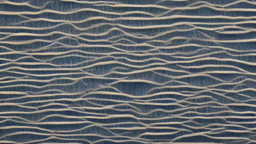

Generating prompts:  93%|█████████████████▋ | 186/200 [1:26:46<06:58, 29.91s/it]

a close up of a zebra print fabric with a black and white stripe, art jiro matsumoto, youtube video screenshot, ultramarine blue, long flowing fins, unmistakably kenyan, terraces, 2 0 1 4. modern attire, ultra intricate, high detail 1024, reef, by Louise Abbéma, rugs, image on the store website


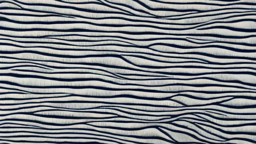

Generating prompts:  94%|█████████████████▊ | 187/200 [1:27:17<06:34, 30.36s/it]

a close up of a blue and white rug with a zebra print, yoichi hatakenaka, still from anime, by Agnes Martin, screengrab, inspired by Katsuchika Hokusai, by Georgia O'Keeffe, fabrics textiles, fluid dynamics, lake scene, 1966, medium detail, stylised design, chris bangle


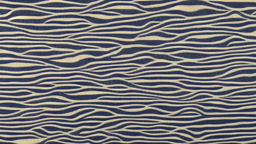

Generating prompts:  94%|█████████████████▊ | 188/200 [1:27:48<06:07, 30.59s/it]

a close up of a blue and yellow striped fabric, joongwon charles jeong, stream of water, treading on calm water, opart, rapids, zulu, liquified, thin strokes, varying dots, saltwater, in an african river, johfra, weightlessness, ( ( dither ) ), trending on artisation


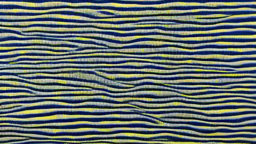

Generating prompts:  94%|█████████████████▉ | 189/200 [1:28:24<05:54, 32.19s/it]

a close up of a blue and white striped fabric with waves, 1 9 7 0 s analog video, bbc earth, by Alex Katz, impressionistic brushwork, aspect ratio 16:9, delicate patterned, blue river in the middle, terraces, metallic surfaces, unique and intricate painting, by Petr Brandl, moire, filmgrain


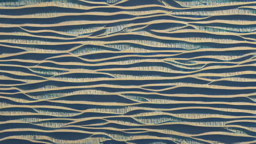

Generating prompts:  95%|██████████████████ | 190/200 [1:28:56<05:18, 31.88s/it]

a close up of a zebra print fabric with a black and white stripe, blue - ray screenshot, rippling water, grain 1 9 9 0, metal cladding wall, duochrome, by Murray Tinkelman, dvd screencapture, scanned, by Gregory Gillespie, illustration iridescent, rapids, reptilian skin, high - definition picture, intricate oil


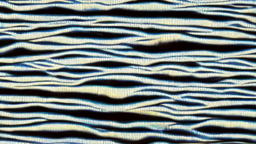

Generating prompts:  96%|██████████████████▏| 191/200 [1:29:28<04:49, 32.11s/it]

a close up of a black and white striped fabric with waves, stop-motion film (1924), dark blue water, jonathan zawada, done in the style of matisse, pat steir, screenshot from a 2012s anime, the thames is dry, webcam screenshot


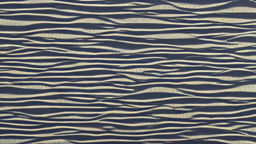

Generating prompts:  96%|██████████████████▏| 192/200 [1:29:48<03:46, 28.31s/it]

a close up of a blue and yellow striped fabric, computer art, inspired by Richard Artschwager, rippling water, television screenshot, this painting is a large canvas, patterned, vibration, cobalt, rapids, hundreds of eyes, frequency indie album cover, james turrel, detail on scene, one line, reeds, blu-ray transfer, scan lines


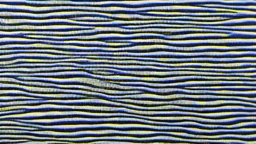

Generating prompts:  96%|██████████████████▎| 193/200 [1:30:25<03:36, 30.96s/it]

a close up of a blue and black striped fabric with a small hole in the middle, dvd screencapture, rippling water, metal scapes, by Richard Artschwager, computer painting, tiger stripes, simple chromatic xray, aliasing visible, polished metal, precisionism, rapids, film still from an cartoon, trending on artstattion, xerography


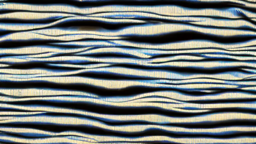

Generating prompts:  97%|██████████████████▍| 194/200 [1:30:55<03:05, 30.86s/it]

a close up of a blue and white wall with a wave pattern, still frame from a movie, by Eleanor Best, stop - motion, tonal topstitching, by Ram Chandra Shukla, denim, youtube video screenshot, made purely out of water, offset printing technique, woodblock, highly detailed and hypnotic, smooth clean texture, no gradients


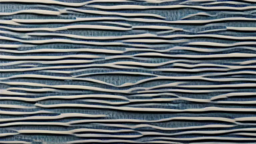

Generating prompts:  98%|██████████████████▌| 195/200 [1:31:24<02:30, 30.12s/it]

a close up of a black and white photo of a wave pattern, layered paper art, by Peter Zumthor, youtube video screenshot, extremely detailed painting, low - relief stone sculpture, flowing rhythms, in this painting, by Perle Fine, repetition, embossed, metal shutter, intimidating floating sand


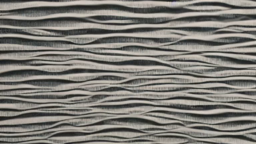

Generating prompts:  98%|██████████████████▌| 196/200 [1:31:50<01:55, 28.86s/it]

a close up of a blue and white wall with wavy lines, still frame from a movie, contemporary ceramics, made purely out of water, finely textured, youtube video screenshot, quilt, by Rodolfo Escalera, featured on dribble, woodcut, heavy impasto technique, incredible sharp detail, denim, c4d


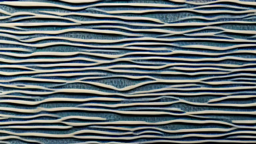

Generating prompts:  98%|██████████████████▋| 197/200 [1:32:17<01:25, 28.52s/it]

a close up of a metal surface with a lot of white stuff, still from a music video, woven with electricity, detailed product image, by David Chipperfield, gray stone wall, noisy filter, escaping air bubbles, undulating nebulous clouds, metal shutter, 3 5 °, dcim, in realistic data center, beautiful flowing fabric, fence


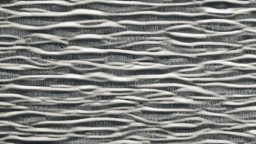

Generating prompts:  99%|██████████████████▊| 198/200 [1:32:50<00:59, 29.74s/it]

a close up of a blue fabric with a wavy pattern, film still from an cartoon, made of brushed steel, by Gilberto Soren Zaragoza, reflective water, stacked image, award-winning painting, 1 2 0 0 dpi scan, white plank siding, in thick layers of rhythms, thick impasto technique, polarizer filter, terraces


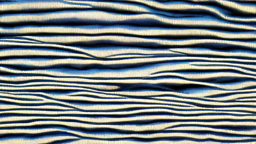

Generating prompts: 100%|██████████████████▉| 199/200 [1:33:17<00:28, 28.93s/it]

a close up of a painting of a wave pattern on a wall, still from the movie ex machina, the thames is dry, ffffound, reeds, offset printing technique, ex machina (2014), teal cloth, repetition, smooth noise, flat water color texture, unknown pleasures, on the calm lake surface, 6 0 s colour palette


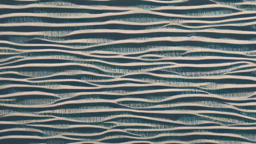

Generating prompts: 100%|███████████████████| 200/200 [1:33:46<00:00, 28.13s/it]





Generated 200 prompts and renamed your files, enjoy!


In [20]:
#@title Batch process a folder of images 📁 -> 📝

#@markdown This will generate prompts for every image in a folder and either save results
#@markdown to a desc.csv file in the same folder or rename the files to contain their prompts.
#@markdown The renamed files work well for [DreamBooth extension](https://github.com/d8ahazard/sd_dreambooth_extension)
#@markdown in the [Stable Diffusion Web UI](https://github.com/AUTOMATIC1111/stable-diffusion-webui).
#@markdown You can use the generated csv in the [Stable Diffusion Finetuning](https://colab.research.google.com/drive/1vrh_MUSaAMaC5tsLWDxkFILKJ790Z4Bl?usp=sharing)

import csv
import os
from IPython.display import clear_output, display
from PIL import Image
from tqdm import tqdm

folder_path = "./framesback"
prompt_mode = 'best' #@param ["best","fast","classic","negative"]
output_mode = 'rename' #@param ["desc.csv","rename"]
max_filename_len = 200 #@param {type:"integer"}


def sanitize_for_filename(prompt: str, max_len: int) -> str:
    name = "".join(c for c in prompt if (c.isalnum() or c in ",._-! "))
    name = name.strip()[:(max_len-4)] # extra space for extension
    return name

ci.config.quiet = True

files = [f for f in os.listdir(folder_path) if f.endswith('.jpg') or f.endswith('.png')] if os.path.exists(folder_path) else []
prompts = []
for idx, file in enumerate(tqdm(files, desc='Generating prompts')):
    if idx > 0 and idx % 100 == 0:
        clear_output(wait=True)

    image = Image.open(os.path.join(folder_path, file)).convert('RGB')
    prompt = image_to_prompt(image, prompt_mode)
    prompts.append(prompt)

    print(prompt)
    thumb = image.copy()
    thumb.thumbnail([256, 256])
    display(thumb)

    if output_mode == 'rename':
        name = sanitize_for_filename(prompt, max_filename_len)
        ext = os.path.splitext(file)[1]
        filename = str(idx)+ "_" + name + ext
        idx = 1
        while os.path.exists(os.path.join(folder_path, filename)):
            print(f'File {filename} already exists, trying {idx+1}...')
            filename = f"{name}_{idx}{ext}"
            idx += 1
        os.rename(os.path.join(folder_path, file), os.path.join(folder_path, filename))

if len(prompts):
    if output_mode == 'desc.csv':
        csv_path = os.path.join(folder_path, 'desc.csv')
        with open(csv_path, 'w', encoding='utf-8', newline='') as f:
            w = csv.writer(f, quoting=csv.QUOTE_MINIMAL)
            w.writerow(['image', 'prompt'])
            for file, prompt in zip(files, prompts):
                w.writerow([file, prompt])

        print(f"\n\n\n\nGenerated {len(prompts)} prompts and saved to {csv_path}, enjoy!")
    else:
        print(f"\n\n\n\nGenerated {len(prompts)} prompts and renamed your files, enjoy!")
else:
    print(f"Sorry, I couldn't find any images in {folder_path}")


In [23]:
!ls framesback

'0_a close up of a piece of fabric with a wave pattern, etching render, by Louise Abbéma, stylistic furniture, inspired by Georgia OKeeffe, blueish moonlight, official product image, sandstone, surfa.png'
'100_zebra print fabric with a blue and white stripe pattern, film still from an cartoon, golden ribbons, lapis lazuli gradients, procedurally generated, medal, dynamic closeup, by Georgia OKeeffe, you.png'
'101_a close up of a black and white striped fabric with a pattern, azure waves of water, youtube video screenshot, by Ross Bleckner, unmistakably kenyan, animation illustrative style, sapphire waters .png'
'102_a close up of a blue and yellow striped fabric with waves, still frame from a movie, 60s, computer art, made purely out of water, subtle junji ito, paper texture. 1968, from lorax movie, intricate.png'
'103_a close up of a zebra print fabric with a black and white stripe, blue - ray screenshot, by Louise Bourgeois, dmt waves, between sedimentary deposits, featured on dribbl

In [24]:
import os

# Specify the directory path
directory_path = './framesback'  # Change this to the path of your directory

# Get the list of files in the directory
file_names = os.listdir(directory_path)

print(file_names)

['46_a close up of a piece of fabric with a blue border, flowing rhythms, youtube video screenshot, by Georgia OKeeffe, optical illusion woodblock print, calm waves, deep learning, between sedimentary .png', '28_a painting of a blue and yellow striped pattern on a wall, still from film, lsd ripples, supercomputer, rivers and lakes, by Adrienn Henczné Deák, animation still, sapphires, woodblock, very very .png', '30_a close up of a wall with a pattern of wavy lines, screenshot from a movie, contemporary ceramics, by Ottó Baditz, greyish tones, mid-century modern, youtube video screenshot, rippling with magic,.png', '14_a close up of a blue and yellow striped fabric, ian david soar, felt tip pen, lemon slices float on the water, heavy grain-s 150, in an african river, opart, narrow eyes, very small brushstrokes, .png', '81_a close up of a blue and white striped fabric with waves, still frame from a movie, instagram art, supercomputer, inspired by Frederick Hammersley, water sprites, smoo

In [26]:
# Specify the name of the output file
output_file = 'file_list.txt'  # Change this to the desired name of your output file

# Write the list of file names to the output file
with open(output_file, 'w', encoding='utf-8') as file:
    for file_name in file_names:
        file.write(file_name + '\n')

print(f"File names have been saved to {output_file}")


File names have been saved to file_list.txt
